# Week 8

In [1]:
import networkx as nx
import io
import urllib
import numpy as np
import nltk
import matplotlib.pyplot as plt
import os
import math
import pickle
%matplotlib inline

## Path Lengths

### Exercises

**Q1:** For each source/target pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths. Mine looks something like this:

In [2]:
# Open file and create graph
wikispedia_graph = nx.DiGraph()
f = io.open('./week8/wikispeedia_paths-and-graph/links.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    links = line.split('\t')
    # skip all retrieved information that is not an edge
    if len(links) != 2:
        continue
    out_node = urllib.unquote(str(links[0])).decode('utf8')
    in_node = urllib.unquote(str(links[1]).replace('\n','')).decode('utf8')
    wikispedia_graph.add_edge(out_node,in_node)
    
# close the file
f.close()

In [3]:
# Find path lengths between every node
path_lengths = nx.shortest_path_length(wikispedia_graph)

In [4]:
all_path_lengths = []

# path_lengths is a dict containing another dict
# From networkx: path[source][target]=L, where L is the length of the shortest path
for node_dict in path_lengths.values():
    # add 
    all_path_lengths.extend(node_dict.values())

# create distributions, use min and max to create bins
min_length = min(all_path_lengths)
max_length = max(all_path_lengths)

bins = [num for num in range(min_length,max_length+1)]
hist, bin_edges = np.histogram(all_path_lengths, bins)

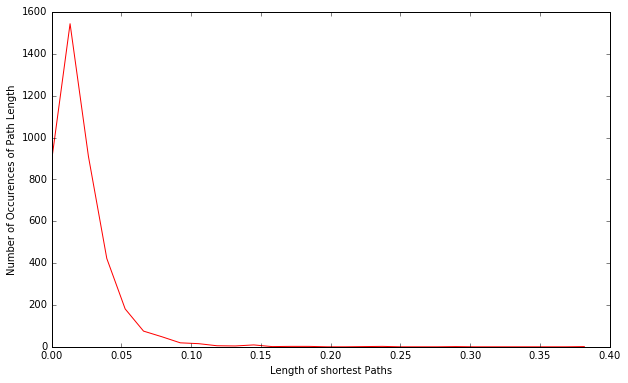

In [124]:
plt.figure(figsize=(10,6))
plt.plot(bin_edges[:-1], hist, 'r-')
plt.ylabel("Number of Occurences of Path Length")
plt.xlabel("Length of shortest Paths")
plt.show()

**Q2:** For each source/target pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. If I ignore back steps, I get this on log-log scale:

In [173]:
# create list to hold all lengths
all_human_lengths = {}

# Open file
f = io.open('./week8/wikispeedia_paths-and-graph/paths_finished.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    table = line.split()
    
    # skip all comments at the top of the file
    if '#' in table or not table:
        continue
    
    # the 4th column contains the path
    path = table[3]
    
    # nodes are semi-colon delimited
    nodes = path.split(';')
        
    source = urllib.unquote(str(nodes[0])).decode('utf8')
    target = urllib.unquote(str(nodes[-1])).decode('utf8')
    
    # if the source and target are the same the game is already over!
    if source == target:
        continue
        
    # length is equal to the total number of nodes found minus all the backspaces
    length = len(nodes) - nodes.count('<')
    
    # path[source][target] = length
    if source in all_human_lengths:
        if target in all_human_lengths[source]:
            all_human_lengths[source][target].append(length)
        else:
            all_human_lengths[source][target] = [length]
    else:
        all_human_lengths[source] = {target: [length]}
    
# close file
f.close()

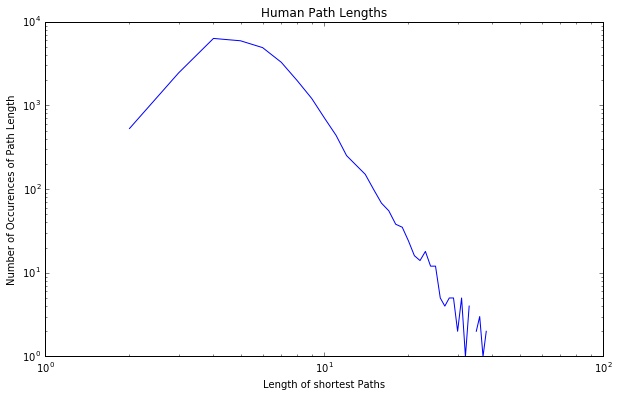

In [174]:
all_human_lengths_values = [np.average(lengths) for source, targets in all_human_lengths.iteritems() for target, lengths in targets.iteritems()]

# create distributions, use min and max to create bins
min_length = int(min(all_human_lengths_values))
max_length = int(max(all_human_lengths_values))

bins = [num for num in range(min_length,max_length+1)]
hist, bin_edges = np.histogram(all_human_lengths_values, bins)

plt.figure(figsize=(10,6))
plt.loglog(bin_edges[:-1], hist, 'b-')
plt.title('Human Path Lengths')
plt.ylabel("Number of Occurences of Path Length")
plt.xlabel("Length of shortest Paths")
plt.show()

**Q3:** How much longer are the human paths on average?

In [8]:
average_path = np.average(all_path_lengths)
average_human_path = np.average(all_human_lengths_values)

print "Human paths are on average %.1f nodes longer." % (average_human_path - average_path)

Human paths are on average 2.8 nodes longer.


Create scatter plot where each point is a source/target pair, and you have human path lengths on the xx-axis and shortests paths on the yy-axis.

In [176]:
x = []
y = []

for human_source, human_targets in all_human_lengths.iteritems():

    # skip if source is not found in path_lengths dict
    if human_source not in path_lengths:
        continue
            
    for human_target, human_lengths in human_targets.iteritems():
        
        # skip if target is not found in path_lengths dict
        if human_target not in path_lengths[human_source]:
            continue
        
        # take human length to be the average of all the path lengths
        human_length = np.average(human_lengths)
        # add human path length
        x.append(human_length)
        
        # retrieve path length using human node and target
        path_length = path_lengths[human_source][human_target]
        # add path length
        y.append(path_length)

NameError: name 'path_lengths' is not defined

In [175]:
plt.figure(figsize=(10,6))
plt.plot(x, y, 'y.', alpha=0.4)
plt.ylabel("Shortest Paths")
plt.xlabel("Human Path Lengths")
plt.show()

NameError: name 'x' is not defined

Is there a correlation between human/shortest path-lengths? What is the correlation.

> ????

## Betweenness

### Exercises

Begin by calculating the betweenness centrality and navigation centrality of all nodes in the wikispedia dataset.

In [11]:
# watch this take 2 hours
betweenness_centrality = nx.betweenness_centrality(wikispedia_graph)

In [12]:
# init dictionary to have all nodes and value = 0
navigation_centrality = dict.fromkeys(wikispedia_graph.nodes(),0.)

# find all lists that 
all_path_lists = nx.shortest_path(wikispedia_graph)
total_paths = 0.

for source, targets in all_path_lists.iteritems():
    for target, path in targets.iteritems():
        total_paths += 1.
        for node in path[1:-1]:
            navigation_centrality[node] += 1.
            
for node, value in navigation_centrality.iteritems():
    navigation_centrality[node] = value / total_paths

KeyboardInterrupt: 

First, list the 5 pages with highest navigation centrality.

In [ ]:
# sort navigation centrality
navigation_centrality_sorted = sorted(navigation_centrality.iteritems(), key=lambda (k,v): -v)

print navigation_centrality_sorted[:5]

Second, list the 5 pages with highest betweenness centrality.

In [ ]:
# sort betweenness centrality
betweenness_centrality_sorted = sorted(betweenness_centrality.iteritems(), key=lambda (k,v): -v)

print betweenness_centrality_sorted[:5]

Compare the two lists. Explain the differences between the two lists in your own words.

> I don't have any words

Create a scatterplot of betweenness centrality vs. navigation centrality.

In [ ]:
btw_values = []
nav_values = []

for node, btw in betweenness_centrality.iteritems():
    btw_values.append(btw)
    
    # use node to get corresponding navigation centrality value
    nav = navigation_centrality[node]
    nav_values.append(nav)


plt.figure(figsize=(12,12))
plt.plot(btw_values, nav_values, 'r.')
plt.ylabel("Navigation Centrality")
plt.xlabel("Betweeness Centrality")
plt.show()

How many pages have zero navigation centrality

In [ ]:
zero_navigation = [node for node, value in navigation_centrality.iteritems() if value == 0]

print "%s nodes have zero navigation centrality." % len(zero_navigation)

What is the the page with zero navigation centrality and highest betweenness centrality? 

In [ ]:
max_centrality = ('',0)
for node in zero_navigation:
    value = betweenness_centrality[node]
    if value > max_centrality[1]:
        max_centrality = (node, value)
        
print max_centrality
print wikipedia_graph

Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).

> ????

Plot the distribution of betweenness centrality for the pages with zero navigation centrality.

In [ ]:
hist, bin_edges = np.histogram([value for node, value in betweenness_centrality.iteritems() if node in zero_navigation])

plt.figure(figsize=(10,6))
plt.loglog(bin_edges[:-1], hist, 'b-')
plt.ylabel("Number of Occurences of Betweenness Centrality")
plt.xlabel("Betweenness Centrality")
plt.show()

What is the correlation between betweenness centrality and navigation centrality?

> ???

Comment on the top 5 outliers.

> ???

## Bringing the text into the picture

### Exercises

First, create a TF-IDF vector for each page. You already know all about TF-IDF from last week's exercise. The main difference is that we now characterize each page by a TF-IDF vector and not a group of pages.

In [2]:
def tokenizer(raw):
    
    # get tokens from raw text
    tokens = nltk.word_tokenize(raw)
    
    # retrieve common stop words form nltk
    stopwords = nltk.corpus.stopwords.words('english')
    
    # isalpha returns true when no special characters and numbers are in a string
    # create stemmed list of tokens not found in remove words or when isaplha is not satisfied
    return [t.lower() for t in set(tokens) if t.lower() not in stopwords and t.isalpha()]

In [3]:
directory = './week8/plaintext_articles'
tokens = {}

try:
    print('Opening dict saved to file')
    with open('tokens.pickle', 'rb') as pickled_f:
        tokens = pickle.load(pickled_f)
        pickled_f.close()
        
except Exception as e:
    print('Creating Dict')
    for filename in os.listdir(directory):
        f = io.open(directory + '/' + filename, encoding='utf-8')
        raw = f.read()
        name = urllib.unquote(str(filename.replace('.txt',''))).decode('utf8')
        tokens[name] = tokenizer(raw)
        f.close()

    with open('tokens.pickle', 'wb') as pickled_f:
            pickle.dump(tokens, pickled_f, pickle.HIGHEST_PROTOCOL)
            pickled_f.close()

Opening dict saved to file


In [170]:
# print tf.values()[10]
key = tf.keys()[2]
print key
print len(tf[key])
print len(set(tokens[key]))
print list(tf[key])[:10]
print tf[key]['caused']

Novelty_(locomotive)
680
680
[u'secondly', u'valve', u'partial', u'caused', u'existing', u'four', u'glyndyfrdwy', u'subjects', u'uneven', u'referring']
1


In [27]:
names = [name for name in tokens]

tf = {}

for name, words in tokens.iteritems():
    fd = nltk.FreqDist(words)
    tf[name] = dict(fd.items())

In [28]:
all_words = []
for name, words in tokens.iteritems():
    all_words.extend(set(words))
    
unique_words = set(all_words)

occurences = dict.fromkeys(unique_words,0.)
# total number of files
N = len(tokens.keys()) 

for word in all_words:
    occurences[word] += 1.
    
idf = {}
for word, occurence in occurences.iteritems():
    idf[word] = math.log(N / occurence,10)

In [62]:
tf_idf = {}

# get all the words for each article
for name, words in tokens.iteritems():
    
    tf_idf[name] = {}
    # for every word inside of that article calculate the idf
    for word in words:
        tf_idf[name][word] = tf[name][word] * idf[word]

In [63]:
len(tf_idf['Hopman_Cup'])

304

In [40]:
len(tokens.keys()) == len(set(tokens.keys()))

True

In [67]:
def cosine_similarity(A,B):
    dot = 0.
    
    if len(B) < len(A):
        A, B = B, A
    
    for word, value in A.iteritems():
        dot += value * B.get(word,0)
    
    return dot / (np.linalg.norm(A.values()) * np.linalg.norm(B.values()))

In [65]:
# test the cosine similarity
test1 = tf_idf.keys()[5]
test2 = tf_idf.keys()[500]
print test1, test2

print list(tf_idf[test1])[:25] == list(tf_idf[test2])[:25]

cos_sim =  cosine_similarity(tf_idf[test1], tf_idf[test2])
print cos_sim

Lead Sulfur
False
927 705
0.145051359399


Calculate the average similarity for all human navigation paths (the source/target pairs from above). Calculate mean/variance of these average similarities.

In [130]:
human_pairs = {}

f = io.open('./week8/wikispeedia_paths-and-graph/paths_finished.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    table = line.split()
    
    # skip all comments at the top of the file
    if '#' in table or not table:
        continue
    
    # the 4th column contains the path
    path = table[3]
    
    # nodes are semi-colon delimited
    nodes = path.split(';')
        
    source = urllib.unquote(str(nodes[0])).decode('utf8')
    target = urllib.unquote(str(nodes[-1])).decode('utf8')
    
    if source == target:
        continue
        
    # if the key already exists then the list of targets also exists
    if source in human_pairs:
        # prevent duplicate targets since they will yield the same result
        if target not in human_pairs[source]:
            human_pairs[source].append(target)
    # if not create the key value mapping between source and a list of targets
    else:
        human_pairs[source] = [target]
    
# close file
f.close()

In [142]:
shortest_path_pairs = {}

f = io.open('./week8/wikispeedia_paths-and-graph/links.tsv', 'r', encoding='utf-8')
for line in f:
    # split on tabs
    links = line.split('\t')
    
    # skip all comments at the top of the file
    if '#' in table or not table or len(links) != 2:
        continue
        
    source = urllib.unquote(str(links[0])).decode('utf8')
    target = urllib.unquote(str(links[1]).replace('\n','')).decode('utf8')
    
    if source == target:
        continue
        
    # if the key already exists then the list of targets also exists
    if source in shortest_path_pairs:
        # prevent duplicate targets since they will yield the same result
        if target not in shortest_path_pairs[source]:
            shortest_path_pairs[source].append(target)
    # if not create the key value mapping between source and a list of targets
    else:
        shortest_path_pairs[source] = [target]

In [157]:
human_similarities = {}

for source, targets in human_pairs.iteritems(): 
    
    # since the keys to the human_pairs dictionary are unique we can
    # init the dictionary here
    human_similarities[source] = {}
    
    # for each target calculate the cosine similarity and save the results in a dictionary
    # dict[source][target] = L where L is a list of cos_sims between the source and target tf-idf
    for target in targets:
        # tf_idf[word] = 
        cos_sim = cosine_similarity(tf_idf[source], tf_idf[target])
        # if we've already seen a source/target pair store the different cos_sim
        if target in human_similarities[source]:
            human_similarities[source][target].append(cos_sim)
        # create a new list to contain all the cos_sims of a source/target pair
        else:
            human_similarities[source][target] = [cos_sim]
        

#         # if the key already exists
#         if source in human_similarities:
#             
#         # the key does not yet exist for create a new dict mapping
#         else:
#             human_similarities[source][target] = [cos_sim]
    

# calculate the average similarity
human_average_similarities = []

# each source has multiple targets
for source, targets in human_similarities.iteritems():
    # each target has 1 or more cosine similarities
    for target, cos_sims in targets.iteritems():
        mean = np.mean(cos_sims)
        partial_sim.append(mean)
        human_average_similarities.append(mean)
        

print "Average similarities stats:"
print "Mean: %f" % np.mean(human_average_similarities)
print "Variance: %f" % np.var(human_average_similarities)
print "Min: %f" % min(human_average_similarities)
print "Max: %f" % max(human_average_similarities)

Average similarities stats:
Mean: 0.031445
Variance: 0.000599
Min: 0.000000
Max: 0.394968


In [167]:
path_similarities = {}

for source, target in shortest_path_pairs.iteritems():
    
    if source not in human_pairs:
        continue
    
    # since the keys to the human_pairs dictionary are unique we can
    # init the dictionary here
    path_similarities[source] = {}
    
    # for each target calculate the cosine similarity and save the results in a dictionary
    # dict[source][target] = L where L is a list of cos_sims between the source and target tf-idf
    for target in targets:
        
        if target == source or target not in human_pairs:
            continue
         
        # tf_idf[word][word] = value
        cos_sim = cosine_similarity(tf_idf[source], tf_idf[target])
        # if we've already seen a source/target pair store the different cos_sim
        if target in path_similarities[source]:
            path_similarities[source][target].append(cos_sim)
        # create a new list to contain all the cos_sims of a source/target pair
        else:
            path_similarities[source][target] = [cos_sim]
    
#     cos_sim = cosine_similarity(tf_idf[source], tf_idf[target])
    
#     # create key using source and target
#     if source in path_similarities:
#         if target in path_similarities[source]:
#             path_similarities[source][target].append(cos_sim)
#         else:
#             path_similarities[source][target] = [cos_sim]
#     else:
#         path_similarities[source] = {target: [cos_sim]}

path_average_similarities = []

for source, targets in path_similarities.iteritems():
    
    for target, cos_sims in targets.iteritems():
        mean = np.mean(cos_sims)
        partial_sim.append(mean)
        path_average_similarities.append(mean)
        
print "Average similarities stats:"
print "Mean: %f" % np.mean(path_average_similarities)
print "Variance: %f" % np.var(path_average_similarities)
print "Min: %f" % min(path_average_similarities)
print "Max: %f" % max(path_average_similarities)
        
# close file
f.close()

Average similarities stats:
Mean: 0.027667
Variance: 0.000358
Min: 0.000000
Max: 0.295705


In [ ]:
print human_similarities.keys()[:30]
print human_similarities['Kubla_Khan']

In [168]:
print len(human_pairs)
print len(human_average_similarities)
print len(path_average_similarities)
print len(names)
print len(list(tf_idf))

4134
28707
66128
4604
4604


In [103]:
print path_similarities.keys()[:30]
print path_similarities['Kubla_Khan']

[u'Hopman_Cup', u'Thomas_Cranmer', u'Novelty_(locomotive)', u'Communism', u'All_You_Need_Is_Love_(The_JAMs_song)', u'Lead', u'Order_of_the_Garter', u'Thallium', u'Gremlins', u'Avocado', u'Poetry', u'Hello_Garci_scandal', u'Tim_Berners-Lee', u'Merseburg_Incantations', u'Davis_Cup', u'Brabham', u'Ray_of_Light', u'Liverpool', u'Starship_Troopers', u'Anemia', u'Crimean_Karaites', u'Phishing', u'Biodiesel', u'Hurricane_Andrew', u'Watch', u'Electric_field', u'Winston_Tunnel', u'GDRT', u'George_Washington', u'18th_century']
{u'Samuel_Taylor_Coleridge': 0.056846539264813693}


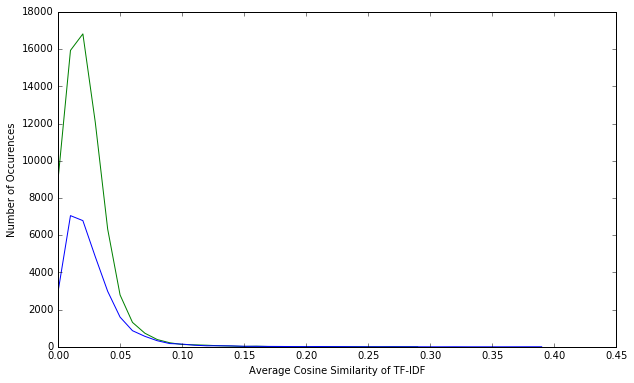

In [169]:
binwidth = 0.01

plt.figure(figsize=(10,6))

data = path_average_similarities
hist, bin_edges = np.histogram(data, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(bin_edges[:-1], hist, 'g-')

data = human_average_similarities
hist, bin_edges = np.histogram(data, bins=np.arange(min(data), max(data) + binwidth, binwidth))
plt.plot(bin_edges[:-1], hist, 'b-')

plt.ylabel("Number of Occurences")
plt.xlabel("Average Cosine Similarity of TF-IDF")
plt.xlim(0,0.45)
plt.show()